In [51]:
# Load useful packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from datetime import datetime
import numpy as np
import pyproj
from dask.diagnostics import ProgressBar
import matplotlib.dates as mdate
import intake
import cftime

In [33]:
# Import SIC observations
sat = xr.open_mfdataset("SICdata/AMSR*.nc", combine='by_coords')

In [2]:
# open cmip6 online catalogue
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)


In [3]:
#cat = col.search(source_id=['UKESM1-0-LL'], 
#                 experiment_id=['historical','piControl'], table_id=['SImon','Ofx'], 
#                 variable_id=['siconc','areacello']) 
                 #member_id=['r1i1p1f1'])  
cat = col.search(source_id=['UKESM1-0-LL'], 
                 experiment_id=['piControl'], table_id=['Ofx'], 
                 variable_id=['areacello']) 
                 #member_id=['r1i1p1f1'])  

cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MOHC,UKESM1-0-LL,piControl,r1i1p1f2,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/piContr...,NaN,20190705


In [4]:
# Create dictionary from the list of datasets we found
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
dset_dict.keys()

dict_keys(['CMIP.MOHC.UKESM1-0-LL.piControl.Ofx.gn'])

In [6]:
areacello = dset_dict[list(dset_dict.keys())[0]]#.isel(member_id = 0).squeeze()
#ukesm_si = dset_dict[list(dset_dict.keys())[2]]

In [7]:
areacello.areacello.values

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [ ]:
ukesm_si.siconc.values.min() 

In [8]:
# Select region of interest from the Areacello variable
areac = areacello.areacello.where((areacello.latitude>=70) & (areacello.latitude<=85) & (areacello.longitude <= 10) & (areacello.longitude >= -10), drop = True)

In [10]:
areac.values

array([[[          nan,           nan,           nan,           nan,
                   nan, 3.4814651e+09, 3.4836024e+09, 3.4848433e+09,
         3.4851761e+09,           nan,           nan,           nan,
                   nan,           nan,           nan,           nan,
                   nan,           nan],
        [          nan,           nan,           nan,           nan,
                   nan, 3.4475753e+09, 3.4500119e+09, 3.4515569e+09,
         3.4522010e+09, 3.4519460e+09, 3.4507868e+09, 3.4487191e+09,
         3.4457428e+09,           nan,           nan,           nan,
                   nan,           nan],
        [          nan,           nan,           nan,           nan,
         3.4110712e+09, 3.4146844e+09, 3.4174136e+09, 3.4192520e+09,
         3.4202020e+09, 3.4202550e+09, 3.4194053e+09, 3.4176609e+09,
         3.4150052e+09, 3.4114524e+09, 3.4069786e+09, 3.4016061e+09,
                   nan,           nan],
        [          nan,           nan,           nan

In [11]:
cat2 = col.search(source_id=['UKESM1-0-LL'], 
                 experiment_id=['historical'], table_id=['SImon'], 
                 variable_id=['siconc',]) 
                 #member_id=['r1i1p1f1'])  


In [12]:
# Create dictionary from the list of datasets we found
dset2_dict = cat2.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [14]:
#dset2_dict.keys()
uk_si = dset2_dict[list(dset2_dict.keys())[1]]

In [17]:
# average over the ensembles
uk_si_en = uk_si.mean(dim = ['member_id'], keep_attrs=True)
# select area of interest: Greenland
uk_si_GL = uk_si_en.where((uk_si_en.longitude>=-10) & (uk_si_en.longitude<=10) & (uk_si_en.latitude <=85 ) & (uk_si_en.latitude >= 70),drop = True)

In [18]:
uk_si_GL

<xarray.Dataset>
Dimensions:             (time: 1980, j: 29, i: 18, vertices: 4, bnds: 2)
Coordinates:
  * i                   (i) int32 267 268 269 270 271 ... 280 281 282 283 284
  * j                   (j) int32 291 292 293 294 295 ... 315 316 317 318 319
    latitude            (j, i) float32 dask.array<chunksize=(29, 18), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(29, 18), meta=np.ndarray>
  * time                (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    type                |S7 b'sea_ice'
Dimensions without coordinates: vertices, bnds
Data variables:
    siconc              (time, j, i) float32 dask.array<chunksize=(672, 29, 18), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(29, 18, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(29, 18, 4), meta=np.ndarray>
Attributes: (12/45)
    Conventions:             CF-1.7 CMIP-6.2
    experiment_id:           historical
    grid_label:              gn
    intake_esm_varname:      ['siconc']
    title:                   UKESM1-0-LL output prepared for CMIP6
    table_info:              Creation Date:(13 December 2018) MD5:f0588f7f55b...
    ...                      ...
    initialization_index:    1
    parent_mip_era:          CMIP6
    external_variables:      areacello
    version_id:              v20200430
    source_id:               UKESM1-0-LL
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.historical.SImon.gn

In [22]:
uk_si_GL['siconc'].values

array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,  0.      ,       nan,
               nan],
        ...,
        [99.596725, 99.59015 , 99.53795 , ...,       nan,       nan,
               nan],
        [99.56527 , 99.56248 , 99.590744, ...,       nan,       nan,
               nan],
        [      nan,       nan, 99.612686, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,  0.      ,       nan,
               nan],
        ...,
        [99.69877 , 99.64943 , 99.63446 , ...,       nan,       nan,
               nan],
        [99.703735, 99.66467 , 99.63463 , ...,       nan,       nan,
   

In [28]:
uk_iceExtent = ((xr.where(uk_si_GL['siconc']>15, 1.,0))*areac).sum(dim=['j','i'])

In [29]:
uk_iceExtent.values


array([[5.33330139e+11],
       [5.28735936e+11],
       [5.25449293e+11],
       ...,
       [2.97195464e+11],
       [3.38042117e+11],
       [3.50673115e+11]])

In [56]:
uk_iceExtent.sel(time = slice('2002','2014'))

<xarray.DataArray (time: 156, member_id: 1)>
dask.array<getitem, shape=(156, 1), dtype=float64, chunksize=(156, 1), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 2002-01-16 00:00:00 ... 2014-12-16 00:00:00
    type       |S7 b'sea_ice'
  * member_id  (member_id) <U8 'r1i1p1f2'

In [53]:
uk_iceExt_obs = uk_iceExtent.sel(time = slice('2002','2014')).groupby('time.month').mean().compute()

In [54]:
uk_iceExt_obs

<xarray.DataArray (month: 12, member_id: 1)>
array([[3.45986616e+11],
       [3.50409049e+11],
       [3.54751511e+11],
       [3.60484402e+11],
       [3.55506301e+11],
       [3.41858627e+11],
       [3.12598518e+11],
       [2.76094871e+11],
       [2.68106327e+11],
       [3.05929083e+11],
       [3.33026736e+11],
       [3.46175048e+11]])
Coordinates:
    type       |S7 b'sea_ice'
  * member_id  (member_id) <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [30]:
uk_iceExt_monthly = uk_iceExtent.groupby('time.month').mean().compute()

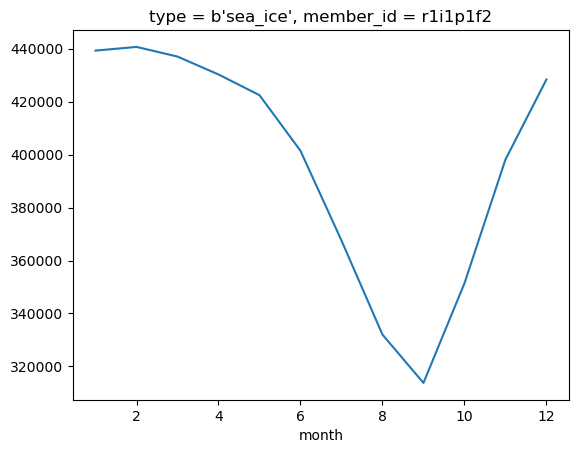

In [31]:
(uk_iceExt_monthly/1e6).plot()

In [34]:
# Using the Satellite data
# Output coordinates are in WGS 84 longitude and latitude
projOut = pyproj.Proj(init='epsg:4326')

# Input coordinates are in meters on the Polar Stereographic 
# projection given in the netCDF file
projIn = pyproj.Proj(init='epsg:3411',
    preserve_units=True)

xx, yy = np.meshgrid( sat.x.values, sat.y.values)
lon,lat= pyproj.transform(projIn, projOut, xx, yy )
sat['lon'] = (('y','x'),lon)
sat['lat'] = (('y','x'),lat)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_573/4168876840.py:11: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon,lat= pyproj.tr

In [35]:
sat

<xarray.Dataset>
Dimensions:              (time: 6117, x: 1216, y: 1792)
Coordinates:
  * x                    (x) float64 -3.847e+06 -3.841e+06 ... 3.747e+06
  * y                    (y) float64 -5.347e+06 -5.341e+06 ... 5.847e+06
  * time                 (time) datetime64[ns] 2002-06-01 ... 2019-12-31
Data variables:
    polar_stereographic  (time) |S1 dask.array<chunksize=(30,), meta=np.ndarray>
    z                    (time, y, x) float32 dask.array<chunksize=(30, 1792, 1216), meta=np.ndarray>
    lon                  (y, x) float64 -80.73 -80.69 -80.65 ... 102.4 102.3
    lat                  (y, x) float64 33.96 33.98 34.01 ... 31.44 31.42 31.4
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  5.2.1 (r15220) [64-bit] [MP]
    history:      Sun Jun 21 02:48:54 2020: GDAL CreateCopy( /ssmi/www/htdocs...
    info:         AMSRE sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 2.1.3, released 2017/20/01

In [36]:
sat_GL = sat.where((sat.lon>=-10) & (sat.lon<=10) & (sat.lat <=85 )  & (sat.lat >= 70),drop = True)

In [38]:
test =areac/1e6
test.values

array([[[      nan,       nan,       nan,       nan,       nan,
         3481.465 , 3483.6025, 3484.8433, 3485.176 ,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan],
        [      nan,       nan,       nan,       nan,       nan,
         3447.5752, 3450.012 , 3451.557 , 3452.201 , 3451.946 ,
         3450.7869, 3448.719 , 3445.743 ,       nan,       nan,
               nan,       nan,       nan],
        [      nan,       nan,       nan,       nan, 3411.0713,
         3414.6843, 3417.4136, 3419.252 , 3420.202 , 3420.255 ,
         3419.4053, 3417.661 , 3415.0051, 3411.4524, 3406.9785,
         3401.6062,       nan,       nan],
        [      nan,       nan,       nan,       nan, 3378.8252,
         3382.716 , 3385.729 , 3387.857 , 3389.1013, 3389.448 ,
         3388.9104, 3387.4697, 3385.1382, 3381.9004, 3377.752 ,
         3372.7148, 3366.7634, 3359.9055],
        [      nan,       nan,       nan,       nan, 3347.42

In [45]:
#area = 6.25**2
#area
#sat_Ext = (xr.where(sat_GL.z>15, 1.,0).sum(dim=['x','y']))*area
#sat_Ext_monthly = sat_Ext.groupby('time.month').mean().compute()
sat_Ext_monthlysd = sat_Ext.groupby('time.month').std().compute()

In [43]:
sat_Ext.values

array([190390.625 , 205429.6875, 199023.4375, ..., 237187.5   ,
       238671.875 , 240664.0625])

In [61]:
sat_Ext_obs = sat_Ext.sel(time = slice('2002','2014')).groupby('time.month').mean().compute()
sat_Ext_obs                         

<xarray.DataArray 'z' (month: 12)>
array([234081.05755132, 238182.32548701, 236472.69061584, 230572.44318182,
       228416.2352071 , 226322.69965278, 201345.41015625, 172792.47553662,
       179150.31413185, 218932.98796791, 224471.93287037, 227834.02637769])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

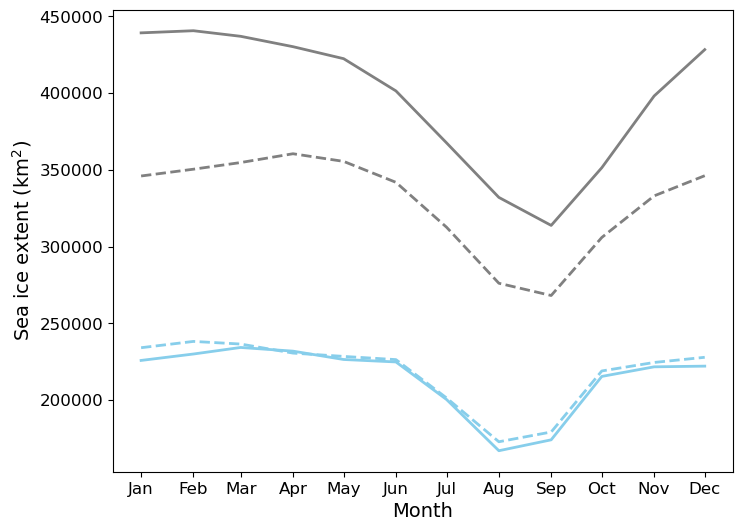

In [62]:
fig, ax = plt.subplots(figsize = (8,6))
with ProgressBar():
    ax.plot([datetime.strptime(str(m).zfill(2), '%m') for m in sat_Ext_monthly.month.values],
            sat_Ext_monthly,
                color='skyblue',
                lw = 2,
           linestyle = '-')
ax.plot([datetime.strptime(str(m).zfill(2), '%m') for m in sat_Ext_monthly.month.values],
            sat_Ext_obs,
                color='skyblue',
                lw = 2,
           linestyle = '--')    
ax.plot([datetime.strptime(str(m).zfill(2), '%m') for m in sat_Ext_monthly.month.values],
            uk_iceExt_monthly/1e6,
                color='grey',
                lw = 2)
ax.plot([datetime.strptime(str(m).zfill(2), '%m') for m in sat_Ext_monthly.month.values],
            uk_iceExt_obs/1e6,
                color='grey',
                lw = 2,
       linestyle = '--')
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel(r'Sea ice extent (km${^2})$', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
fmt = mdate.DateFormatter('%b')
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_major_locator(mdate.MonthLocator())